In [1]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
import numpy as np

### resampling to a common 1m grid

In [3]:
# Resample Each Raster to 1m Grid
def resample_to_grid(input_raster_path, output_raster_path, dst_crs, transform, width, height):
    with rasterio.open(input_raster_path) as src:
        data = src.read(1)
        dst_data = np.empty((height, width), dtype='float32')

        reproject(
            source=data,
            destination=dst_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.average  # or nearest, cubic, etc.
        )

        dst_meta = src.meta.copy()
        dst_meta.update({
            "driver": "GTiff",
            "height": height,
            "width": width,
            "transform": transform,
            "crs": dst_crs,
            "dtype": "float32",
            "nodata": -9999
        })

        dst_data = np.where(np.isnan(dst_data), -9999, dst_data)

        with rasterio.open(output_raster_path, 'w', **dst_meta) as dst:
            dst.write(dst_data, 1)

In [31]:
with rasterio.open('rescaled_twice_raster_UAV_ETa.tif') as src:
    data = src.read(1).astype(np.float32)
    
    # Replace known nodata values (e.g., -9999) or use src.nodata
    nodata_val = src.nodata if src.nodata is not None else -9999
    data[data == nodata_val] = np.nan  # Convert nodata to NaN
    
    # Optionally filter out invalid values (e.g., ≤ 0)
    data[data <= 0] = np.nan

    # Now safely get min/max ignoring NaNs
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)

print(f"Min: {min_val}, Max: {max_val}")

Min: 3.0, Max: 5.650000095367432


In [4]:
from rasterio.transform import from_origin

# Open a raster to define extent
with rasterio.open('clipped_rescaled_PS_ETa_08032022.tif') as ref:
    bounds = ref.bounds
    dst_crs = ref.crs

# Define new transform and shape at 1m resolution
resolution = 1.0
width = int((bounds.right - bounds.left) / resolution)
height = int((bounds.top - bounds.bottom) / resolution)
transform = from_origin(bounds.left, bounds.top, resolution, resolution)

In [ ]:
resample_to_grid('clipped_raster_LS_ETa_08032022.tif', 'LS_ETa_30m_resampled_1m.tif', dst_crs, transform, width, height)
resample_to_grid('clipped_rescaled_PS_ETa_08032022.tif', 'PS_ETa_3m_resampled_1m.tif', dst_crs, transform, width, height)
resample_to_grid('rescaled_twice_raster_UAV_ETa.tif', 'UAV_ETa_5cm_resampled_1m.tif', dst_crs, transform, width, height)

#### clip UAV ETa to the field boundaries

In [55]:
import os
from rasterio import mask as rst_mask

GBfarm_shapefile_dir = os.path.join(os.getcwd(),  'Boundaries', 'Gatesburg', 'Farm_size.shp')
GBfarm_shapefile = gpd.read_file(GBfarm_shapefile_dir).to_crs(4326)

raster_path = 'UAV_ETa_5cm_resampled_1m.tif'
shapefile_path = GBfarm_shapefile_dir
output_path = 'UAV_ETa_5cm_resampled_1m_clipped.tif'

# Read shapefile and reproject to match raster CRS
with rasterio.open(raster_path) as src:
    raster_crs = src.crs

gdf = gpd.read_file(shapefile_path)
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

# Extract geometry
geoms = gdf.geometry.values

with rasterio.open(raster_path) as src:
    out_image, out_transform = rst_mask.mask(src, geoms, crop=True, nodata=src.nodata)
    out_meta = src.meta.copy()

# Convert to float32 and assign np.nan where needed
out_image = out_image.astype('float32')
out_image[out_image == src.nodata] = np.nan  # handle existing nodata
out_image = out_image


# Update metadata to use float32 and optional float nodata
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "dtype": "float32",
    "nodata": -9999  # use a real float nodata (can't be np.nan in saved file)
})

# Replace np.nan with -9999 for saving
out_image = np.where(np.isnan(out_image), -9999, out_image)

# Save clipped raster
with rasterio.open(output_path, 'w', **out_meta) as dst:
    dst.write(out_image)

##### clip landsat raster again to the field boundaries

In [50]:
import os
from rasterio import mask as rst_mask

GBfarm_shapefile_dir = os.path.join(os.getcwd(),  'Boundaries', 'Gatesburg', 'Farm_size.shp')
GBfarm_shapefile = gpd.read_file(GBfarm_shapefile_dir).to_crs(4326)

raster_path = 'LS_ETa_30m_resampled_1m.tif'
shapefile_path = GBfarm_shapefile_dir
output_path = 'LS_ETa_30m_resampled_1m_clipped.tif'

# Read shapefile and reproject to match raster CRS
with rasterio.open(raster_path) as src:
    raster_crs = src.crs

gdf = gpd.read_file(shapefile_path)
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

# Extract geometry
geoms = gdf.geometry.values

with rasterio.open(raster_path) as src:
    out_image, out_transform = rst_mask.mask(src, geoms, crop=True, nodata=src.nodata)
    out_meta = src.meta.copy()

# Convert to float32 and assign np.nan where needed
out_image = out_image.astype('float32')
out_image[out_image == src.nodata] = np.nan  # handle existing nodata
out_image = out_image


# Update metadata to use float32 and optional float nodata
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "dtype": "float32",
    "nodata": -9999  # use a real float nodata (can't be np.nan in saved file)
})

# Replace np.nan with -9999 for saving
out_image = np.where(np.isnan(out_image), -9999, out_image)

# Save clipped raster
with rasterio.open(output_path, 'w', **out_meta) as dst:
    dst.write(out_image)

#### Plot original and resampled maps

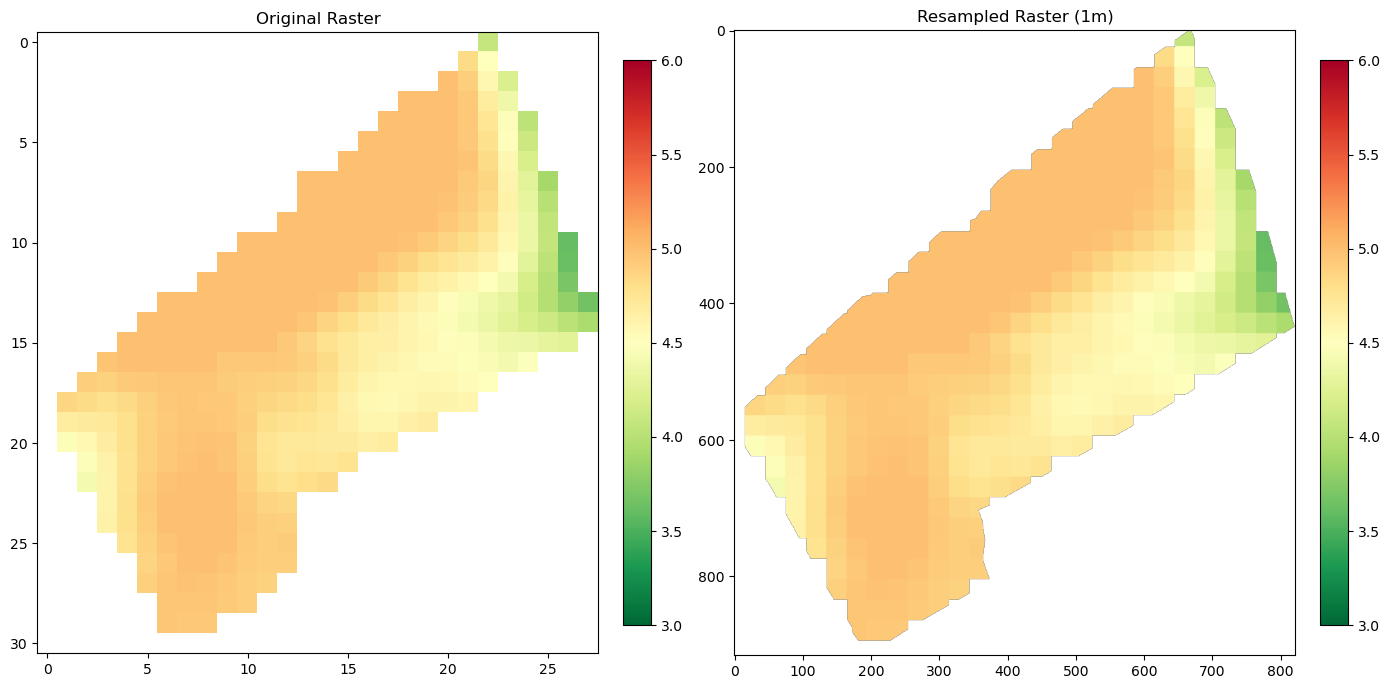

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these paths with your actual file paths
orig_path = "clipped_raster_LS_ETa_08032022.tif"
resampled_path = "LS_ETa_30m_resampled_1m_clipped.tif"

# Load original raster
with rasterio.open(orig_path) as src:
    orig_data = src.read(1)
    orig_profile = src.profile
    orig_data = np.ma.masked_equal(orig_data.astype(float), -9999)
    

# Load resampled raster
with rasterio.open(resampled_path) as src:
    resampled_data = src.read(1)
    resampled_profile = src.profile
    resampled_data = np.ma.masked_equal(resampled_data.astype(float), -9999)
    resampled_data = np.ma.masked_less(resampled_data, 0)



# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
vmin=3; vmax=6
# Plot original
im1 = axes[0].imshow(orig_data, cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin, vmax=vmax)
axes[0].set_title("Original Raster")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot resampled
im2 = axes[1].imshow(resampled_data, cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin, vmax=vmax )
axes[1].set_title("Resampled Raster (1m)")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [35]:
with rasterio.open("UAV_ETa_5cm_resampled_1m.tif") as src:
    pixel_size = src.res  # (x_resolution, y_resolution)
    print(f"Pixel size: {pixel_size[0]} x {pixel_size[1]} units")
    print(src.crs)

Pixel size: 1.0 x 1.0 units
EPSG:32617


In [59]:
import rasterio
import numpy as np

raster_path = "UAV_ETa_5cm_resampled_1m_clipped.tif"

with rasterio.open(raster_path) as src:
    data = src.read(1)

    # Get nodata value
    nodata_val = src.nodata if src.nodata is not None else -9999

    # Total number of pixels
    total_pixels = data.size

    # Count valid pixels (exclude nodata)
    valid_pixels = np.sum(data != nodata_val)

print(f"Total pixels: {total_pixels}")
print(f"Valid pixels: {valid_pixels}")

Total pixels: 752952
Valid pixels: 338748


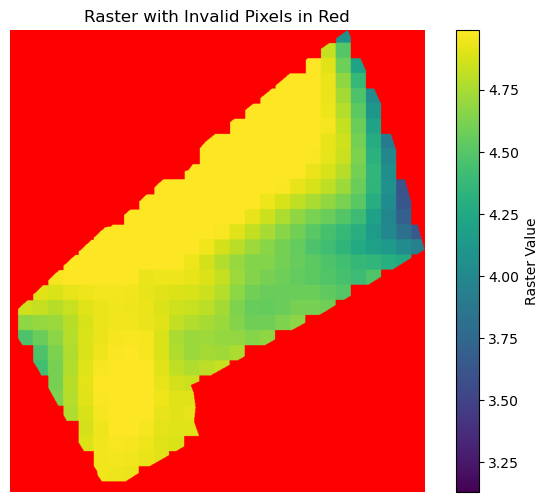

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

raster_path = "LS_ETa_30m_resampled_1m_clipped.tif"

# Read raster
with rasterio.open(raster_path) as src:
    data = src.read(1).astype(np.float32)
    meta = src.meta.copy()
    nodata = src.nodata if src.nodata is not None else -9999

# Create mask for invalid pixels
invalid_mask = (data <= 0) | (data == nodata) | np.isnan(data)

# Mask invalid values for normal colormap
data_masked = np.where(invalid_mask, np.nan, data)

if np.isnan(np.nan):
    meta.update(dtype='float32', nodata=np.nan)
else:
    meta.update(nodata=np.nan)

# Write to new raster
with rasterio.open(f'{raster_path[:-4]}_filtered.tif', 'w', **meta) as dst:
    dst.write(data_masked, 1)

# Create custom colormap: normal cmap + red for invalid
cmap = plt.cm.viridis
cmap.set_bad(color='red')  # red where masked (invalid)

# Plot
plt.figure(figsize=(8, 6))
img = plt.imshow(data_masked, cmap=cmap)
plt.colorbar(img, label="Raster Value")
plt.title("Raster with Invalid Pixels in Red")
plt.axis("off")
plt.show()

### convert rasters to gdfs and keep x and y (espg:32617)

In [26]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

def raster_to_gdf(raster_path, value_threshold=0):
    """
    Converts a raster to a GeoDataFrame of pixel centers and values above a threshold.
    
    Parameters:
        raster_path (str): Path to the input raster file.
        value_threshold (float): Only include pixels with values > this threshold.
    
    Returns:
        GeoDataFrame: Contains 'value', 'x', 'y', and 'geometry' columns.
    """
    with rasterio.open(raster_path) as src:
        data = src.read(1).astype(float)
        transform = src.transform
        crs = src.crs

    # Find valid pixel indices and values
    rows, cols = np.where(data > value_threshold)
    values = data[rows, cols]
    
    # Get coordinates of pixel centers
    xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

    # Create a GeoDataFrame
    df = pd.DataFrame({
        'value': values,
        'x': xs,
        'y': ys
    })
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs=crs)

    return gdf

In [27]:
LS_gdf = raster_to_gdf("LS_ETa_30m_resampled_1m_clipped_filtered.tif", value_threshold=0)
PS_gdf = raster_to_gdf("PS_ETa_3m_resampled_1m.tif", value_threshold=0)
UAV_gdf = raster_to_gdf("UAV_ETa_5cm_resampled_1m_clipped.tif", value_threshold=0)

### Compute semivariogram

#### Binned

In [6]:

import geopandas as gpd
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def compute_semivariogram_dask(gdf, value_col='value', n_lags=30, max_distance=None, sample_size=50000):
    """
    Computes an empirical semivariogram using Dask for large datasets.

    Parameters:
        gdf (GeoDataFrame): Input data.
        value_col (str): Column name with variable values.
        n_lags (int): Number of distance bins.
        max_distance (float): Maximum lag distance. If None, uses 1/2 max pairwise dist.
        sample_size (int): Number of points to sample.

    Returns:
        lag_bins, semivariance: Arrays for plotting
    """
    # Subsample (this still helps reduce load)
    if len(gdf) > sample_size:
        gdf = gdf.sample(n=sample_size, random_state=42)

    coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
    values = gdf[value_col].values

    # Create Dask arrays
    d_coords = da.from_array(coords, chunks=(1000, 2))
    d_values = da.from_array(values, chunks=1000)

    # Compute pairwise distances and value differences
    dists = da.linalg.norm(d_coords[:, None, :] - d_coords[None, :, :], axis=-1)
    diffs = (d_values[:, None] - d_values[None, :]) ** 2

    # Convert to 1D arrays (flattened upper triangle)
    dists_flat = da.triu(dists, k=1).flatten()
    diffs_flat = da.triu(diffs, k=1).flatten()

    # Remove zero or NaN entries
    valid = (~da.isnan(dists_flat)) & (dists_flat > 0)
    dists_flat = dists_flat[valid]
    diffs_flat = diffs_flat[valid]

    # Compute max lag
    if max_distance is None:
        max_distance = np.percentile(dists_flat.compute(), 90)  # or 'median'

    bins = np.linspace(0, max_distance, n_lags + 1)
    bin_indices = da.digitize(dists_flat, bins) - 1

    # Compute semivariance per bin
    semivars = []
    bin_centers = []
    for i in range(n_lags):
        print(i)
        mask = bin_indices == i
        count = mask.sum().compute()
        if count > 0:
            semivar = 0.5 * diffs_flat[mask].mean().compute()
            semivars.append(semivar)
            bin_centers.append((bins[i] + bins[i + 1]) / 2)

    return np.array(bin_centers), np.array(semivars)

In [8]:
LS_lags_1, LS_semivars_1 = compute_semivariogram_dask(LS_gdf, value_col='value', n_lags=50, max_distance=50, sample_size=50000)

c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(
c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(
c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(
c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [9]:
PS_lags_1, PS_semivars_1 = compute_semivariogram_dask(PS_gdf, value_col='value', n_lags=50, max_distance=50, sample_size=50000)

c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(
c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(
c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(
c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [10]:
UAV_lags_1, UAV_semivars_1 = compute_semivariogram_dask(UAV_gdf, value_col='value', n_lags=50, max_distance=50, sample_size=50000)

c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(
c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(
c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(
c:\Users\adadkhah\AppData\Local\miniconda3\envs\SVgram\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [86]:
import matplotlib as mpl
import matplotlib as mpl

plt.style.use('bmh')

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

plt.figure(figsize=(10, 3))

plt.plot(UAV_lags_1, UAV_semivars_1, marker='^', markersize=7, markeredgecolor='black', linestyle='None',markerfacecolor='none',label='UAV ETa')

plt.plot(PS_lags_1, PS_semivars_1, marker='s', markersize=7, markeredgecolor='black',linestyle='None',markerfacecolor='none', label='Predicted ETa')
plt.plot(LS_lags_1, LS_semivars_1, marker='x', markersize=7, markeredgecolor='black', markerfacecolor='none',linestyle='None',label='Landsat ETa')


#plt.title("Empirical Semivariograms")
plt.xlabel("Lag Distance (m)")
plt.ylabel("Semivariance")
legend = plt.legend()
legend.get_frame().set_facecolor("white")  # or any hex/color name
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
plt.grid(True)
plt.xlim(left=0)
plt.tight_layout()
#plt.savefig('SV_ETa.png', dpi=300, transparent=True)
plt.show()

NameError: name 'UAV_lags_1' is not defined

<Figure size 1000x300 with 0 Axes>

In [ ]:
LS_lags_1

(49,)

#### Get the variogram cloud


In [92]:

import numpy as np
import dask.array as da
from dask.diagnostics import ProgressBar

def compute_variogram_cloud_dask(gdf, value_col='value', max_distance=20, chunk_size=5000):
    """
    Compute raw variogram cloud using Dask in chunked batches.

    Parameters:
        gdf (GeoDataFrame): Must contain Point geometry and value column.
        value_col (str): Name of the column containing values.
        max_distance (float): Max distance (lag) to include.
        chunk_size (int): Chunk size for batching.

    Returns:
        dists_all (np.ndarray): Pairwise distances (flattened).
        semivars_all (np.ndarray): Pairwise semivariances (flattened).
    """
    coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
    values = gdf[value_col].values

    coords_dask = da.from_array(coords, chunks=(chunk_size, 2))
    values_dask = da.from_array(values, chunks=(chunk_size,))

    dists_all = []
    semivars_all = []

    with ProgressBar():
        for i in range(0, len(coords), chunk_size):
            for j in range(i + 1, len(coords), chunk_size):
                c1 = coords_dask[i:i+chunk_size].compute()
                c2 = coords_dask[j:j+chunk_size].compute()
                v1 = values_dask[i:i+chunk_size].compute()
                v2 = values_dask[j:j+chunk_size].compute()

                dists = np.linalg.norm(c1[:, None, :] - c2[None, :, :], axis=-1)
                sqdiffs = 0.5 * (v1[:, None] - v2[None, :]) ** 2

                mask = (dists <= max_distance) & (~np.isnan(sqdiffs))
                dists_all.append(dists[mask])
                semivars_all.append(sqdiffs[mask])

    return np.concatenate(dists_all), np.concatenate(semivars_all)

In [93]:
LS_dist, LS_semivars = compute_variogram_cloud_dask(LS_gdf, value_col='value', max_distance=50)

[########################################] | 100% Completed | 104.93 ms
[########################################] | 100% Completed | 102.27 ms
[########################################] | 100% Completed | 103.47 ms
[########################################] | 100% Completed | 102.87 ms
[########################################] | 100% Completed | 102.43 ms
[########################################] | 100% Completed | 102.45 ms
[########################################] | 100% Completed | 105.04 ms
[########################################] | 100% Completed | 101.89 ms
[########################################] | 100% Completed | 102.81 ms
[########################################] | 100% Completed | 102.32 ms
[########################################] | 100% Completed | 102.69 ms
[########################################] | 100% Completed | 102.10 ms
[########################################] | 100% Completed | 102.64 ms
[########################################] | 100% Completed | 10

In [95]:
np.save("LS_dist.npy", LS_dist)
np.save("LS_semivars.npy", LS_semivars)

In [94]:
PS_dist, PS_semivars = compute_variogram_cloud_dask(PS_gdf, value_col='value', max_distance=50) 

[########################################] | 100% Completed | 168.29 ms
[########################################] | 100% Completed | 104.12 ms
[########################################] | 100% Completed | 103.14 ms
[########################################] | 100% Completed | 102.86 ms
[########################################] | 100% Completed | 103.01 ms
[########################################] | 100% Completed | 102.32 ms
[########################################] | 100% Completed | 103.32 ms
[########################################] | 100% Completed | 102.94 ms
[########################################] | 100% Completed | 103.85 ms
[########################################] | 100% Completed | 102.71 ms
[########################################] | 100% Completed | 102.47 ms
[########################################] | 100% Completed | 102.91 ms
[########################################] | 100% Completed | 102.81 ms
[########################################] | 100% Completed | 10

MemoryError: Unable to allocate 10.6 GiB for an array with shape (1424649742,) and data type float64

In [9]:
np.save("PS_dist.npy", PS_dist)
np.save("PS_semivars.npy", PS_semivars)

In [ ]:
UAV_dist, UAV_semivars = compute_variogram_cloud_dask(UAV_gdf, value_col='value', max_distance=50)

[########################################] | 100% Completed | 103.27 ms
[########################################] | 100% Completed | 102.72 ms
[########################################] | 100% Completed | 102.89 ms
[########################################] | 100% Completed | 102.50 ms
[########################################] | 100% Completed | 102.58 ms
[########################################] | 100% Completed | 102.08 ms
[########################################] | 100% Completed | 103.18 ms
[########################################] | 100% Completed | 102.33 ms
[########################################] | 100% Completed | 103.50 ms
[########################################] | 100% Completed | 101.73 ms
[########################################] | 100% Completed | 102.65 ms
[########################################] | 100% Completed | 105.43 ms
[########################################] | 100% Completed | 103.67 ms
[########################################] | 100% Completed | 10

In [11]:
np.save("UAV_dist.npy", UAV_dist)
np.save("UAV_semivars.npy", UAV_semivars)

#### Plot the variogram

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
LS_dist = np.load("LS_dist.npy")
LS_semivars = np.load("LS_semivars.npy")

PS_dist = np.load("PS_dist.npy")
PS_semivars = np.load("PS_semivars.npy")

UAV_dist = np.load("UAV_dist.npy")
UAV_semivars = np.load("UAV_semivars.npy")

In [5]:
LS_dist.shape

(274683313,)

In [22]:


def plot_variogram_cloud_with_binned(dists, semivars, bin_width=1.0, max_dist=20):
    """
    Plot a variogram cloud and its binned means using NumPy for the binning/averaging.

    Parameters
    ----------
    dists : 1D array-like
        Pairwise distances.
    semivars : 1D array-like
        Corresponding semivariance values.
    bin_width : float, optional
        Width of each lag‐distance bin (default: 1.0).
    max_dist : float, optional
        Maximum lag distance to include (default: 20).
    """
    
    d = np.asarray(dists)
    s = np.asarray(semivars)

    # 1) filter to max_dist
    mask = d <= max_dist
    d = d[mask]
    s = s[mask]
    print('Step 1')

    # 2) define bins and centers
    bins = np.arange(0, max_dist + bin_width, bin_width)
    bin_centers = bins[:-1] + (bin_width / 2)
    print('Step 2')
    # 3) assign each distance to a bin index
    # np.digitize returns indices in [1..len(bins)], subtract 1 to get [0..len(bins)-1]
    bin_idx = np.digitize(d, bins) - 1

    # 4) compute mean semivariance per bin
    binned = np.full(bin_centers.shape, np.nan, dtype=float)
    for i in range(len(bin_centers)):
        sel = bin_idx == i
        if np.any(sel):
            binned[i] = s[sel].mean()
    print('Step 4')
   
    # 5) plot
    plt.figure(figsize=(4, 4))
    #plt.scatter(d, s, alpha=0.05, s=5, color='gray', label='Variogram Cloud')
    plt.plot(bin_centers, binned, marker='x', markersize=7, markeredgecolor='black', markerfacecolor='none',linestyle='None',
             label=f'{bin_width}m Binned Mean')

    plt.xlabel("Lag Distance (m)", fontsize=12)
    plt.ylabel("Semivariance", fontsize=12)
    plt.title("Predicted", fontsize=14)
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()
    plt.show()

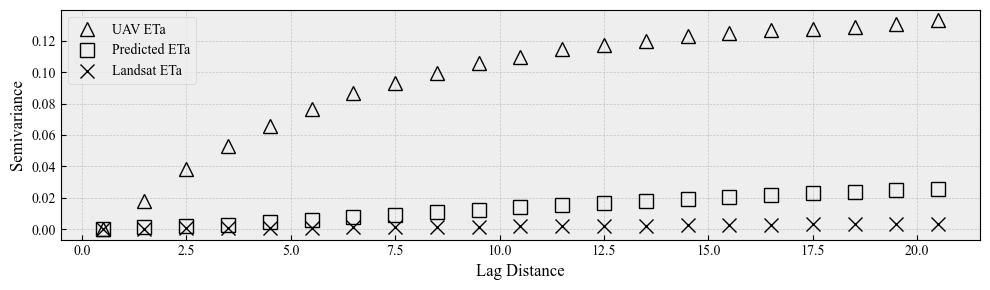

In [ ]:
# — Replace these with your actual arrays —
# dists_uav, semivars_uav
# dists_predicted, semivars_predicted
# dists_landsat, semivars_landsat
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

bin_width = 1.0
max_dist  = 50.0

# create bin edges and centers
bins       = np.arange(0, max_dist + bin_width, bin_width)
bin_centers = bins[:-1]  

plt.figure(figsize=(10,3))

for d, s, label, marker, ls in zip(
    (UAV_dist, PS_dist, LS_dist),
    (UAV_semivars, PS_semivars, LS_semivars),
    ("UAV ETa", "Predicted ETa", "Landsat ETa"),
    ('^', 's', 'x'),
    ('-', '--', ':')
):
    # restrict to max_dist
    mask = d <= max_dist
    # assign each point to a bin
    idx = np.digitize(d[mask], bins) - 1
    # compute mean semivariance per bin
    binned = [
        s[mask][idx == i].mean() if np.any(idx == i) else np.nan
        for i in range(len(bin_centers))
    ]
    # plot
    plt.plot(bin_centers, binned, marker=marker, markersize=10,  markeredgecolor='black',linestyle='None',markerfacecolor='none', label=label)

plt.xlabel("Lag Distance")
plt.ylabel("Semivariance")
#plt.title("Comparison of Semivariograms")
legend = plt.legend()
legend.get_frame().set_facecolor("white")  # or any hex/color name
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
plt.grid(True)
plt.xlim(left=0)
plt.tight_layout()
plt.show()

Step 1
Step 2
Step 4


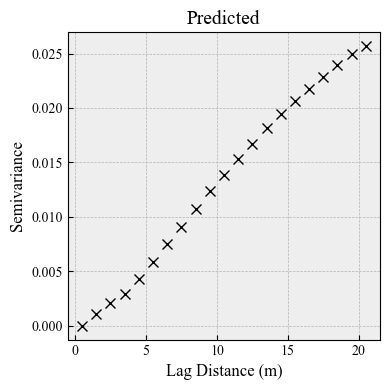

In [87]:
plot_variogram_cloud_with_binned(PS_dist, PS_semivars, bin_width=1.0, max_dist=50)

### Generate variogram with 5000 random points First run

In [37]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

In [103]:
def plot_semivariogram(
    gdf,
    value_col: str = 'value',
    sample_size: int = 5000,
    n_lags: int = 30,
    max_distance: float = None,
    y_max: float = None,
    plot_max_distance: float = None,
    cloud_plot_size: int = 200_000,
    seed: int = 42
):
    """
    1) Samples up to `sample_size` points (random_state=`seed`).
    2) Computes all pairwise semivariance & distances (NumPy/SciPy).
    3) Subsamples the variogram cloud to `cloud_plot_size`.
    4) Computes the empirical semivariogram with `n_lags` equally‑spaced bins up to `max_distance`.
    5) Plots both the cloud and the binned means, but only out to `plot_max_distance` on the x‑axis.

    Parameters
    ----------
    gdf : GeoDataFrame
        Point data with a geometry column.
    value_col : str
        Name of the value column.
    sample_size : int
        Number of points to sample (default 5 000).
    n_lags : int
        Number of lag bins (UI‑controlled).
    max_distance : float or None
        Maximum lag distance for binning; if None, uses 90th percentile of all pairwise distances.
    plot_max_distance : float or None
        Maximum x‑axis distance to plot; if None, shows entire `max_distance`.
    cloud_plot_size : int
        Number of cloud points to scatter (default 200 000).
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    None  # Displays the Matplotlib figure
    """
    # 1) sample
    if len(gdf) > sample_size:
        gdf = gdf.sample(n=sample_size, random_state=seed)

    # 2) extract coords & values
    coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
    vals   = gdf[value_col].values

    # 3) all pairwise
    dists   = pdist(coords, metric='euclidean')
    sq_diffs = pdist(vals.reshape(-1,1), metric='sqeuclidean')
    semivars = 0.5 * sq_diffs

    # 4) set max_distance if needed
    if max_distance is None:
        max_distance = np.percentile(dists, 90)

    # 5) bin into n_lags
    bins = np.linspace(0, max_distance, n_lags+1)
    idx  = np.digitize(dists, bins) - 1
    valid = (idx >= 0) & (idx < n_lags)

    counts = np.bincount(idx[valid], minlength=n_lags)
    sums   = np.bincount(idx[valid], weights=semivars[valid], minlength=n_lags)
    with np.errstate(divide='ignore', invalid='ignore'):
        binned = sums / counts
    binned[counts == 0] = np.nan
    centers = bins[:-1]

    # 6) prepare cloud subset
    mask_cloud = dists <= (plot_max_distance or max_distance)
    d_cloud = dists[mask_cloud]
    s_cloud = semivars[mask_cloud]
    n_pts = min(len(d_cloud), cloud_plot_size)
    rng = np.random.default_rng(seed)
    sel = rng.choice(len(d_cloud), size=n_pts, replace=False)
    d_sub, s_sub = d_cloud[sel], s_cloud[sel]

    # 7) plot
    fig, ax = plt.subplots(figsize=(10,3))
    #ax.scatter(d_sub, s_sub,
               #s=2, alpha=0.1,
               #color='gray', label='Variogram cloud')
    ax.scatter(centers, binned,
               s=100,                  # make these big enough to see
               color='Blue',
               marker='+',
               label='Binned means')

    # axis limits
    xlim = plot_max_distance or max_distance
    ax.set_xlim(0, xlim)

    # apply axis limits
    ax.set_xlim(0, xlim)
    if y_max is not None:
        ax.set_ylim(0, y_max)
        
    ax.set(
        xlabel='Lag distance',
        ylabel='Semivariance',
        title=''
    )
    ax.grid(True,alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

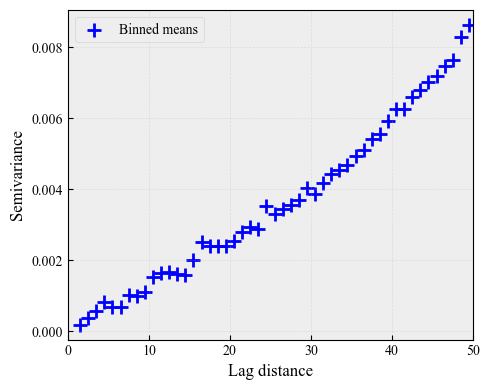

In [97]:
plot_semivariogram(
    LS_gdf,
    value_col='value',
    sample_size=5000,
    n_lags=50,
    max_distance=50,        # or set a fixed max
    y_max= None,
    
    seed=123
)

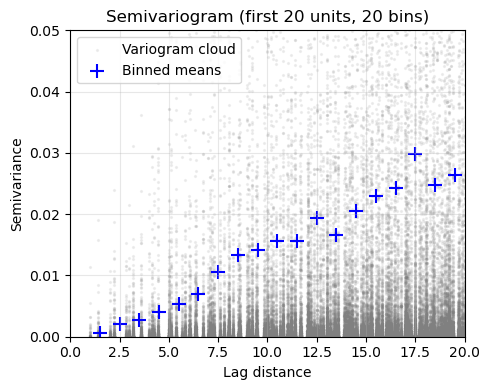

In [81]:
plot_semivariogram(
    PS_gdf,
    value_col='value',
    sample_size=5000,
    n_lags=20,
    max_distance=20,        # or set a fixed max
    y_max= 0.05,
    
    seed=123
)

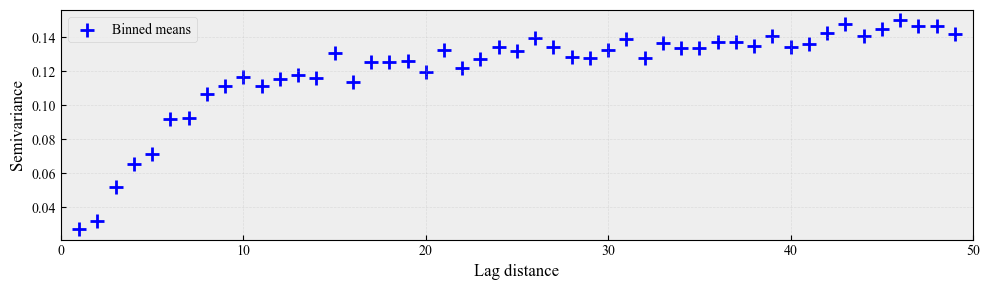

In [104]:
plot_semivariogram(
    UAV_gdf,
    value_col='value',
    sample_size=5000,
    n_lags=50,
    max_distance=50, 
    y_max= None,
    
    seed=42
)

94


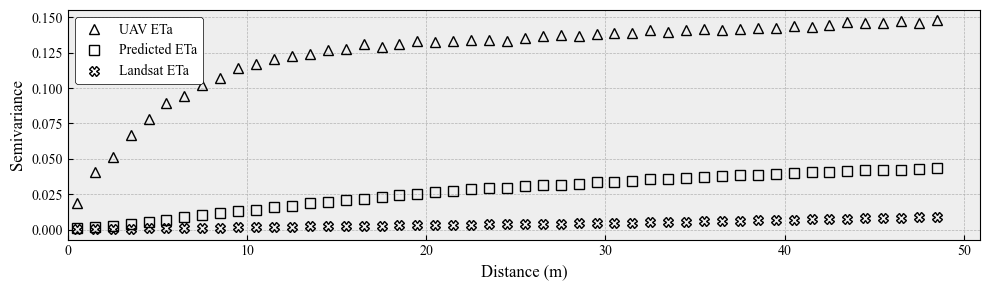

In [158]:
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

bin_width = 1.0
max_dist  = 50

# create bin edges and centers
bins       = np.arange(0, max_dist + bin_width, bin_width)
bin_centers = bins[:-1] - bin_width/2

# 1) sample
    

plt.figure(figsize=(10,3))
seed = np.random.randint(1,100)
print(seed)
for d, label, marker, ls in zip(
    (UAV_gdf, PS_gdf, LS_gdf),
    ("UAV ETa", "Predicted ETa", "Landsat ETa"),
    ('^', 's', 'X'),
    ('-', '--', ':')
):
    
    if len(d) > 25000:
        d = d.sample(n=25000, random_state=42)

    # 2) extract coords & values
    coords = np.vstack([d.geometry.x, d.geometry.y]).T
    vals   = d['value'].values

    # 3) all pairwise
    dists   = pdist(coords, metric='euclidean')
    sq_diffs = pdist(vals.reshape(-1,1), metric='sqeuclidean')
    semivars = 0.5 * sq_diffs

    # restrict to max_dist
    mask = dists <= max_dist
    # assign each point to a bin
    idx = np.digitize(dists[mask], bins) - 1
    # compute mean semivariance per bin
    binned = [
        semivars[mask][idx == i].mean() if np.any(idx == i) else np.nan
        for i in range(len(bin_centers))
    ]
    # plot
    plt.plot(bin_centers, binned, marker=marker, markersize=7,  markeredgecolor='black',linestyle='None',markerfacecolor='none', label=label)

plt.xlabel("Distance (m)")
plt.ylabel("Semivariance")
#plt.title("Comparison of Semivariograms")
legend = plt.legend()
legend.get_frame().set_facecolor("white")  # or any hex/color name
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
plt.grid(True)
plt.xlim(left=0)
plt.tight_layout()
plt.savefig('Three_SVs.png', dpi=300, transparent=True)
plt.show()

##### First run (ignore)

In [ ]:
lags, semivars = compute_semivariogram_dask(LS_gdf, value_col='value', n_lags=30, max_distance=None, sample_size=50000)

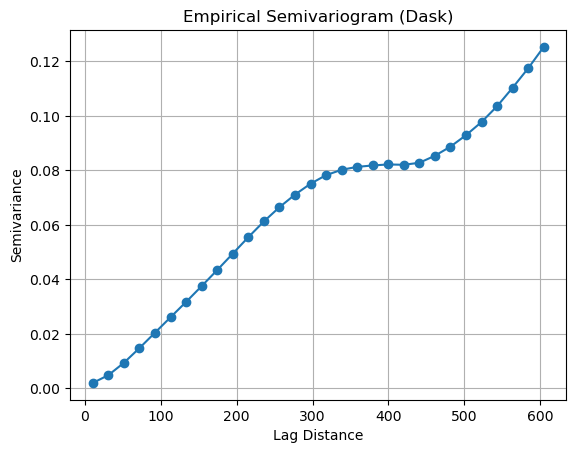

In [19]:
plt.plot(lags, semivars, marker='o')
plt.title("Empirical Semivariogram (Dask)")
plt.xlabel("Lag Distance")
plt.ylabel("Semivariance")
plt.grid(True)
plt.show()

In [20]:
PS_lags, PS_semivars = compute_semivariogram_dask(PS_gdf, value_col='value', n_lags=30, max_distance=None, sample_size=50000)

In [39]:
UAV_lags, UAV_semivars = compute_semivariogram_dask(UAV_gdf, value_col='value', n_lags=30, max_distance=None, sample_size=50000)

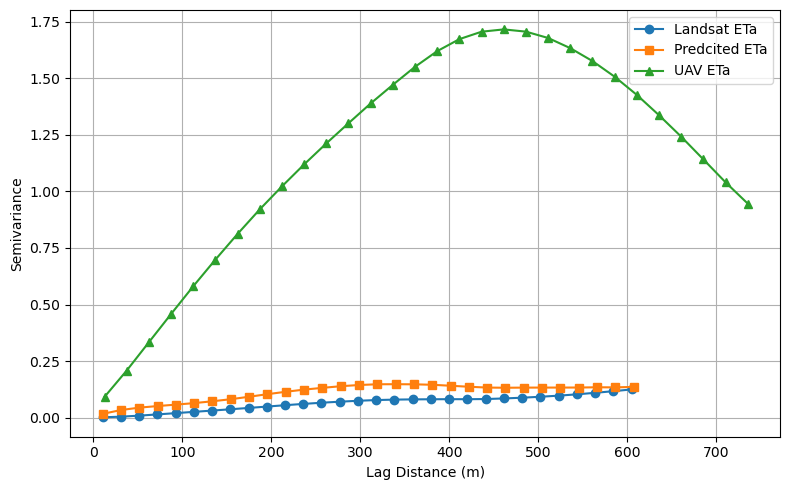

In [40]:
plt.figure(figsize=(8, 5))

plt.plot(lags, semivars, marker='o', label='Landsat ETa')
plt.plot(PS_lags, PS_semivars, marker='s', label='Predcited ETa')
plt.plot(UAV_lags, UAV_semivars, marker='^', label='UAV ETa')

#plt.title("Empirical Semivariograms")
plt.xlabel("Lag Distance (m)")
plt.ylabel("Semivariance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()